# Image Processing SoSe 2024 - Assignment - 08

### Deadline is 20.06.2024 at 12:00 p.m.

#### Students: Vinzent Hannes Jörß, Minh Tuan Nguyen

Please solve the assignments together with a partner.

Make sure the code runs without errors, when clicking `Kernel` -> `Restart Kernel & Run All Cells`. Then save the notebook and upload your submission.

In [3]:
# display the plots inside the notebook
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage.data import chelsea
from skimage.color import rgb2gray
from scipy.fft import dctn as scipy_dctn, idctn as scipy_idctn

pylab.rcParams['figure.figsize'] = (16, 16)   # This makes the plot bigger

# Exercise 1 - 2D DCT - 4 Points
Transform a picture with 2D DCT (discrete cosine transform), which you must implement manually using DCT-II.
For the 2D-DCT, perform two 1D-DCT-transformations. Therefore, implement a method which returns a normalized DCT-II matrix. Plot a normalized 16x16 DCT-II-matrix (with colors reflecting the values in the matrix).

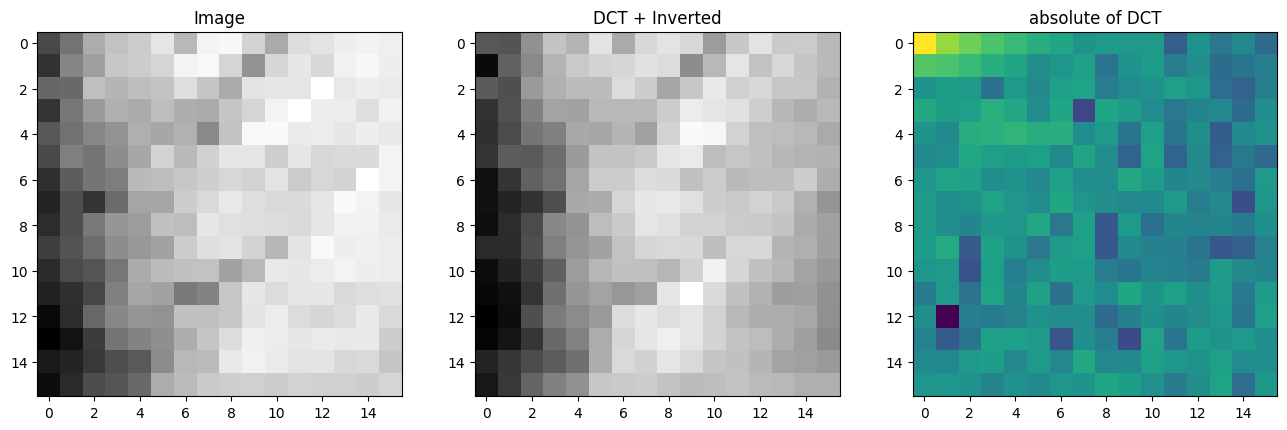

In [5]:
def old_functions(img):
    def dct2d_on_window(matrix):
        dctRow = np.apply_along_axis(dct1d, axis=1, arr=matrix)
        dctFull = np.apply_along_axis(dct1d, axis=0, arr=dctRow)
        
        return dctFull
    
    def dct2d_final(img, window_size = 8):
        
        height, width = img.shape
        result = np.zeros_like(img, dtype=float)
        
        for i in range(0, height, window_size):
            for j in range(0, width, window_size):
                window = img[i:i+window_size, j:j+window_size]
                
                # fill up with zeros, if window not big enough 
                if window.shape[0] < window_size or window.shape[1] < window_size:
                    padded_window = np.zeros((window_size, window_size))
                    padded_window[:window.shape[0], :window.shape[1]] = window
                    window = padded_window
                    
                dct_window = dct2d_on_window(window)
                result[i:i+window_size, j:j+window_size] = dct_window[:window.shape[0], :window.shape[1]]
        
        return result

def dct2d(img):
    """
    Returns the 2d discrete cosine transformation
    """
    # your code here
    def dct1d(vector):
        N = len(vector)
        result = np.zeros_like(vector)
        
        #used of formula from wikipedia: https://en.wikipedia.org/wiki/Discrete_cosine_transform#M-D_DCT-II
        for k in range(N):
            sumValue = 0
            for n in range(N):
                sumValue += vector[n] * np.cos((np.pi / N) * (n + 0.5) * k)
            result[k] = sumValue
            
            #normalizing
            result[k] = sumValue * (np.sqrt(1 / N) if k == 0 else np.sqrt(2 / N))
        return result
    
    dctRow = np.apply_along_axis(dct1d, axis=1, arr=img)
    dctMatrix = np.apply_along_axis(dct1d, axis=0, arr=dctRow)
    
    return dctMatrix

def inv_dct2d(img):
    """
    Returns the 2d inverse discrete cosine transformation
    """
    # your code here
    def inv_dct1d(vector):
        """Compute the normalized 1D IDCT-III of an array."""
        N = len(vector)
        result = np.zeros_like(vector)
        
        x0_with_div = vector[0] / np.sqrt(2)
        
        for n in range(N):
            sum_value = x0_with_div
            for k in range(1, N):
                sum_value += vector[k] * np.cos((np.pi / N) * (k + 0.5) * n)
            result[n] = np.sqrt(2 / N) * sum_value

        return result
    
    dctRow = np.apply_along_axis(inv_dct1d, axis=1, arr=img)
    dctMatrix = np.apply_along_axis(inv_dct1d, axis=0, arr=dctRow)
    
    return dctMatrix
    
def extract_center_patch(image, windowSize):
    center_y, center_x = image.shape[0] // 2, image.shape[1] // 2
    start_y, start_x = center_y - windowSize // 2, center_x - windowSize // 2
    return image[start_y:start_y + windowSize, start_x:start_x + windowSize]

windowSize = 16
chelsea_window = extract_center_patch(rgb2gray(chelsea()/255.0),windowSize)

def chess_board(n=8, field_size=32):
    board = np.zeros((n*field_size, n*field_size))
    s = field_size
    for i in range(n):
        for j in range(n):
            if (i + j) % 2 == 0:
                board[i*s:(i+1)*s, j*s:(j+1)*s] = 1
    return board

#for pic in [chess_board(), rgb2gray(chelsea())/255.0]:
for pic in [chelsea_window]:
    plt.subplot(231)
    plt.title("Image")
    plt.imshow(pic, cmap='gray')
    plt.subplot(232)
    plt.title("DCT + Inverted")
    plt.imshow(inv_dct2d(dct2d(pic)), cmap='gray')
    plt.subplot(233)
    plt.title("absolute of DCT")
    plt.imshow(np.log10(1e-9 + np.abs(dct2d(pic))))
    plt.show()

# Exercise 2 - 1 Point: (Manual calculation, no code needed.)

Given is a signal `[5,10,12]`. Now you have to mirror the signal as in the lectures (resulting in a signal of length 5) and perform a DFT. Please write down all coefficients in the frequency spectrum. What do you see (one sentence)?

Siehe PDF: ip_ueb08_exercise02_joerss_nguyen.pdf

# Exercise 3 - High and Low Pass filter with 2D DCT - 5 Points

Implement the `high_pass` and `low_pass` functions which work on the frequency spectrum of a 2D-DCT
transformed image. Apply the filters to both the chessboard and cat image and transform the
result back into image space.

Show the spectrum before and after filtering as well as the resulting images after backtransformation
into image space.

I used the scipy functions for dct and inverse dct, because my own solution takes too long to calculate on this images...

In [6]:
def high_pass(img_ft, n):
    """Removes the low frequencies"""
    # your code here
    def hp_mask(img, cutoff):
        height, width = img.shape
        mask = np.zeros_like(img)
        for i in range(height):
            for j in range(width):
                if i + j > cutoff:
                    mask[i,j] = 1
        return mask
    ft = img_ft.copy()
    ft = ft * hp_mask(img_ft, n)
    return ft

def low_pass(img_ft, n):
    """Removes the high frequencies"""
    # your code here
    def lp_mask(img, cutoff):
        height, width = img.shape
        mask = np.zeros_like(img)
        for i in range(height):
            for j in range(width):
                if i + j < cutoff:
                    mask[i,j] = 1
        return mask
    
    ft = img_ft.copy()
    ft = ft * lp_mask(img_ft, n)
    return ft
    
def inv_dct_and_plot(img_ft):
    plt.imshow(scipy_idctn(img_ft), cmap='gray')
    plt.show()

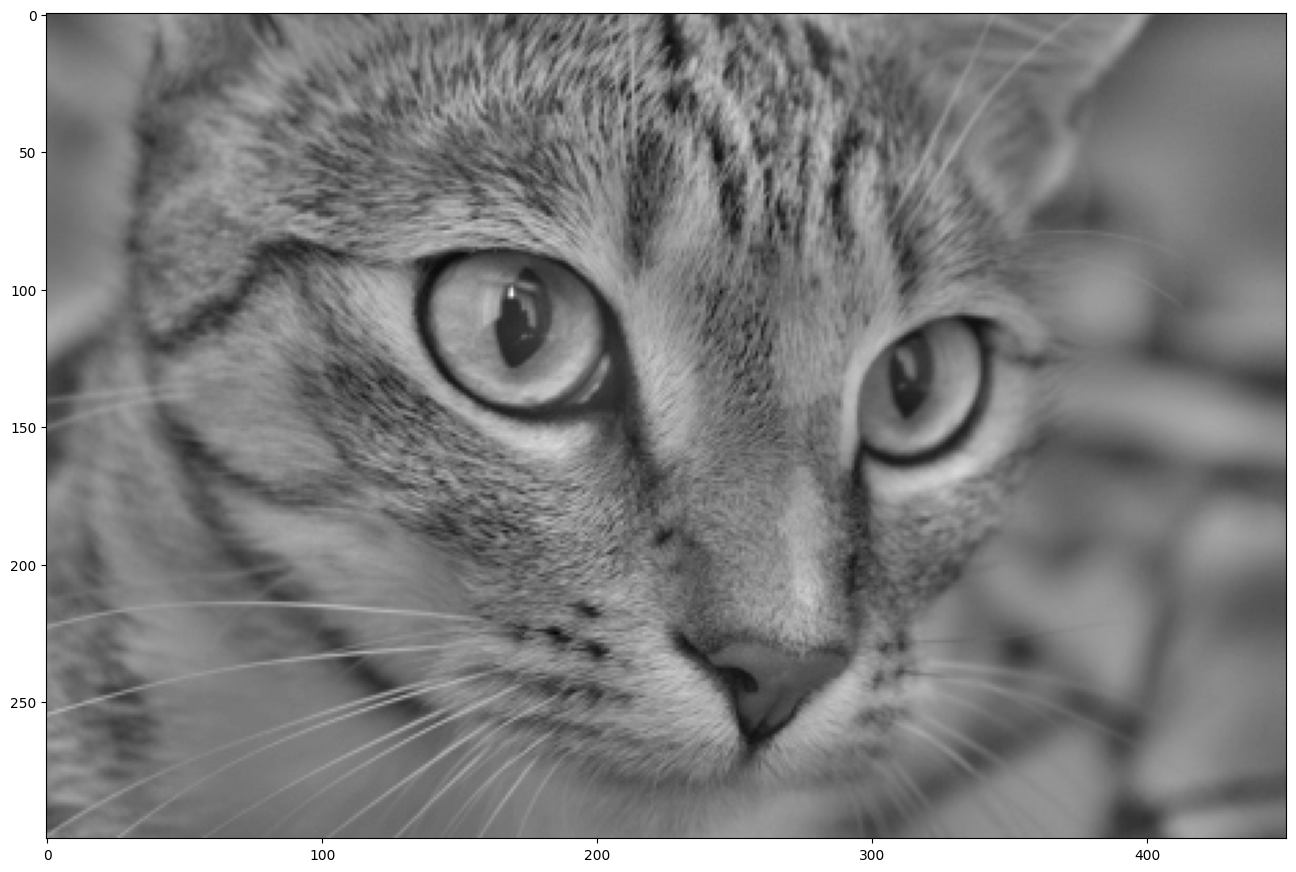

In [7]:
img = rgb2gray(chelsea() / 255)
# remove the low frequencies
chelsea_high_freq = high_pass(scipy_dctn(img), 12)
inv_dct_and_plot(chelsea_high_freq)

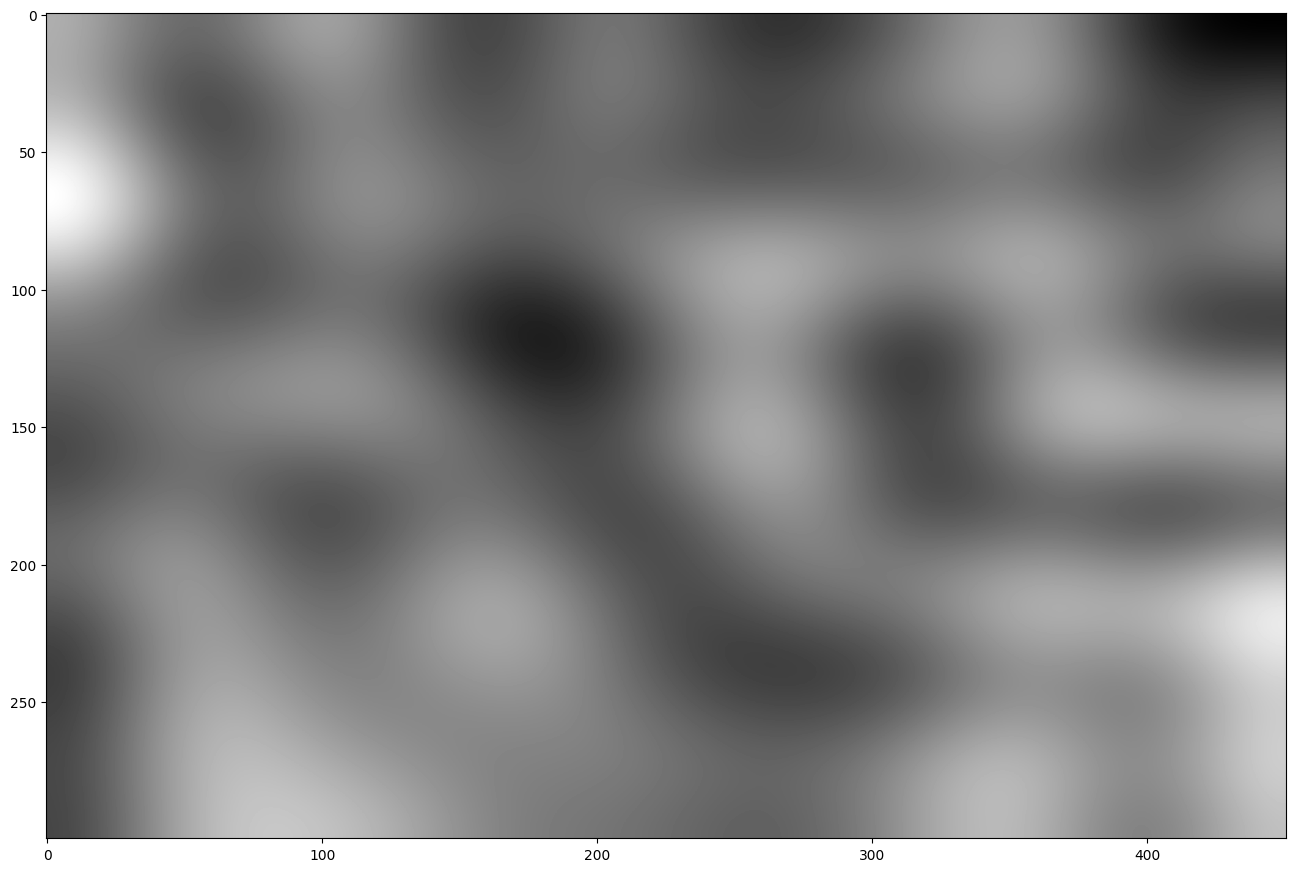

In [8]:
# remove the high frequencies
chelsea_low_freq = low_pass(scipy_dctn(img), 12)
inv_dct_and_plot(chelsea_low_freq)

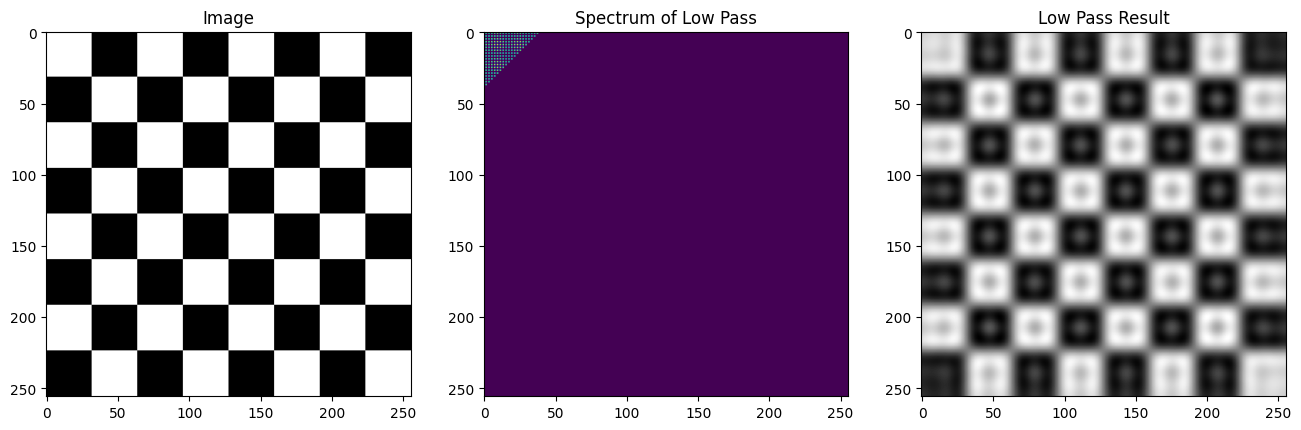

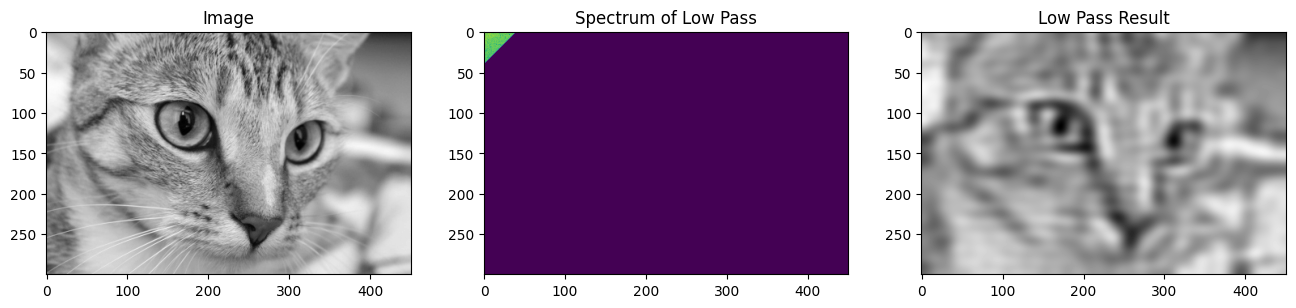

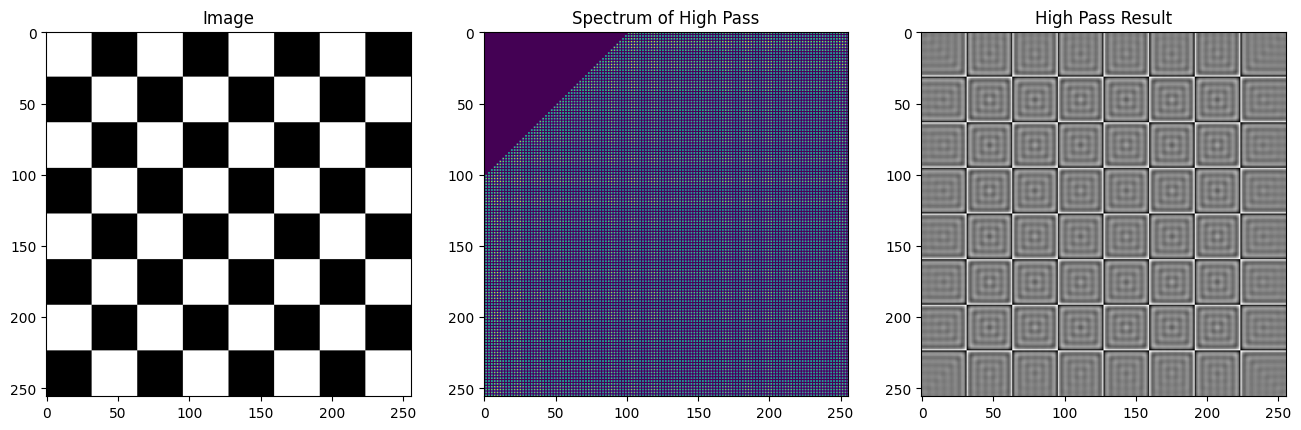

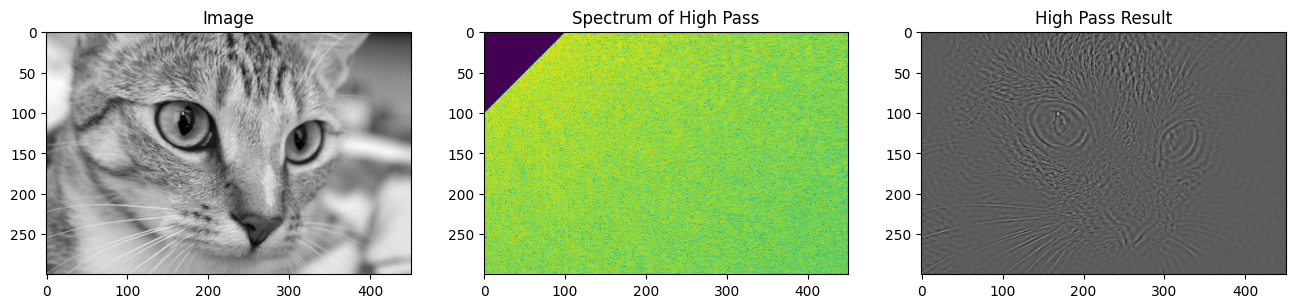

In [19]:
low_pass_cutoff = 40
high_pass_cutoff = 100

for pic in [chess_board(), rgb2gray(chelsea())/255.0]:
    plt.subplot(231)
    plt.title("Image")
    plt.imshow(pic, cmap='gray')
    plt.subplot(232)
    plt.title("Spectrum of Low Pass")
    plt.imshow(np.log10(1e-9 + np.abs(low_pass(scipy_dctn(pic),low_pass_cutoff))))
    plt.subplot(233)
    plt.title("Low Pass Result")
    plt.imshow(scipy_idctn(low_pass(scipy_dctn(pic),low_pass_cutoff)), cmap='gray')
    plt.show()

for pic in [chess_board(), rgb2gray(chelsea())/255.0]:
    plt.subplot(231)
    plt.title("Image")
    plt.imshow(pic, cmap='gray')
    plt.subplot(232)
    plt.title("Spectrum of High Pass")
    plt.imshow(np.log10(1e-9 + np.abs(high_pass(scipy_dctn(pic),high_pass_cutoff))))
    plt.subplot(233)
    plt.title("High Pass Result")
    plt.imshow(scipy_idctn(high_pass(scipy_dctn(pic),high_pass_cutoff)), cmap='gray')
    plt.show()